In [1]:
## importing packages
import torch
import os
import sys
import joypy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

## exposing path 
sys.path.insert(0, "../")

from int_filt.experiments import create_experiment
from int_filt.utils import (
    configuration,
    ensure_reproducibility, 
    move_batch_to_device,
    dump_config,
    construct_time_discretization
)

In [2]:
## globals
ACTIVATIONS = {
    "relu": torch.nn.ReLU()
}

OPTIMIZERS = {
    "sgd": torch.optim.SGD,
    "adam": torch.optim.Adam,
    "adam-w": torch.optim.AdamW
}

SCHEDULERS = {
    "none": None,
    "cosine-annealing": torch.optim.lr_scheduler.CosineAnnealingLR
}

DEVICES = {
    "cpu": torch.device("cpu"),
    "cuda": torch.device("cuda")
}

In [3]:
## defining configurations
DEBUG = False
experiment_config = {
    ## simulation config
    "experiment": "nlg",
    "non_linearity": "sin",
    "num_dims": 1,
    "num_sims": 1_000,
    "num_iters": 1_000 if DEBUG else 1_000_000,
    "num_burn_in_steps": 0,
    "step_size": 1e-3,
    "sigma_x": 1e-2,
    "sigma_y": 1e-0,
    "beta": 1e-0,
    ## interpolant config
    "epsilon": 1.8e-2,
    #"epsilon": 1e-2,
    "interpolant_method": "pffp_v0",
    ## model config
    "b_net_amortized": False,
    "b_net_activation": "relu",
    "b_net_hidden_dims": [1028],
    "b_net_activate_final": False,
    ## training config
    "b_net_lr": 1e-3,
    "num_grad_steps": 1 if DEBUG else 300,
    "b_net_scheduler": "none",
    "b_net_optimizer": "adam-w",
    ## mc estimation config
    "num_mc_samples": 10 if DEBUG else 750,
    ## preprocessing config
    "preprocessing": "sim",
    ## sampling config
    "num_samples": 10 if DEBUG else 450,
    "num_time_steps": 10 if DEBUG else 1_000,
    "num_ar_steps": 10 if DEBUG else 100,
    "full_out": True,
    "initial_time_step": 0,
    "ar_sample_train": False,
    ## logging config
    "log_results": False,
}
## parsing default arguments
args = configuration(args=[])

## creating experiment
args = vars(args)

## setting current configurations
for k, v in experiment_config.items():
    args[k] = v

## optional logging
if args["log_results"]:
    ## creating dump dir 
    path = Path(args["dump_dir"])
    path.mkdir(parents=True, exist_ok=True)
    dump_config(args, os.path.join(args["dump_dir"], "config.json"))

## retrieving activations
args["b_net_activation"] = ACTIVATIONS[args["b_net_activation"]]
## retrieving device
args["device"] = DEVICES[args["device"]]

## adding mc configuration
args["mc_config"] = {"num_mc_samples": args["num_mc_samples"]}

## reproducibility
ensure_reproducibility(args["random_seed"])

## displaying current arguments
print(args)

## creating experiment
experiment = create_experiment(args)
## displaying simulations shape
print(f"{experiment.ssm.train_sim["latent_states"].shape}, {experiment.ssm.train_sim["observations"].shape}")

{'interpolant_method': 'pffp_v0', 'epsilon': 0.018, 'num_mc_samples': 750, 'backbone': 'mlp', 'b_net_hidden_dims': [1028], 'b_net_activation': ReLU(), 'b_net_activate_final': False, 'b_net_amortized': False, 'c_net_hidden_dims': [64], 'c_net_activation': 'relu', 'c_net_activate_final': False, 'experiment': 'nlg', 'sigma_x': 0.01, 'sigma_y': 1.0, 'beta': 1.0, 'num_dims': 1, 'num_sims': 1000, 'num_iters': 1000000, 'num_burn_in_steps': 0, 'non_linearity': 'sin', 'step_size': 0.001, 'log_results': False, 'logging_step': 1, 'log_dir': './log/out/2024-06-27/run_2024-06-27_12-47-40', 'dump_dir': './log/exp/2024-06-27/run_2024-06-27_12-47-40', 'num_grad_steps': 300, 'b_net_optimizer': 'adam-w', 'b_net_scheduler': 'none', 'b_net_lr': 0.001, 'b_net_amortized_optimizer': 'adam-w', 'b_net_amortized_scheduler': 'none', 'b_net_amortized_lr': 0.001, 'c_net_optimizer': 'adam-w', 'c_net_scheduler': 'none', 'c_net_lr': 0.001, 'observation_model': 'gaussian', 'gde': 'interpolant-gde', 'controlled': False

100%|██████████| 999999/999999 [00:25<00:00, 38534.46it/s]


torch.Size([1000000, 1000, 1]), torch.Size([1000000, 1000, 1])


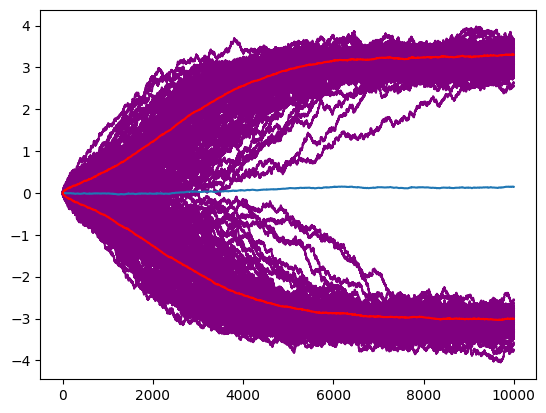

In [4]:
## plotting simulation 
PLOT_SIMULATION = True
JOYPLOT = False
if PLOT_SIMULATION:
    ## defining number of trajectories and time steps to plot
    num_trajectories = 200
    num_time_steps = 10000
    ## retrieving data
    latent_states = torch.squeeze(experiment.ssm.train_sim["latent_states"])[:num_time_steps, :num_trajectories]
    observations = torch.squeeze(experiment.ssm.train_sim["latent_states"])[:num_time_steps, :num_trajectories]
    ## computing statistics of states
    latent_states_mean = torch.mean(latent_states, dim = 1)
    latent_states_std = torch.std(latent_states, dim = 1)
    ## computing statistics of states
    observations_mean = torch.mean(observations, dim = 1)
    observations_std = torch.std(observations, dim = 1)
    ## plotting statistics over time
    fig, axes = plt.subplots()
    ## plotting latent states
    axes.plot(latent_states, color = "purple")
    axes.plot(latent_states_mean)
    axes.plot(latent_states_mean + latent_states_std, color = "red")
    axes.plot(latent_states_mean - latent_states_std, color = "red")
    if args["log_results"]:
        experiment.writer.add_figure("simulated ssm", fig)
        
if JOYPLOT:
    ## retrieving data
    latent_states = torch.squeeze(experiment.ssm.train_sim["latent_states"]).numpy().T
    observations_nlg_exp = torch.squeeze(experiment.ssm.train_sim["latent_states"]).numpy().T
    ## constructing data frame
    observation_indices = np.arange(args["num_iters"])
    observation_indices = np.arange(num_iters_to_plot)
    latent_states_nlg_exp = pd.DataFrame(latent_states_nlg_exp[:num_observations_to_plot, :num_iters_to_plot], columns = observation_indices)
    ## ridge plot
    fig, axes = joypy.joyplot(latent_states_nlg_exp, ylabels=False)

x0 torch.Size([1000, 1])
x1 torch.Size([1000, 1])
xc torch.Size([1000, 1])
y torch.Size([1000, 1])


100%|██████████| 1001/1001 [00:00<00:00, 9255.52it/s]

torch.Size([1001, 1000, 1])


True


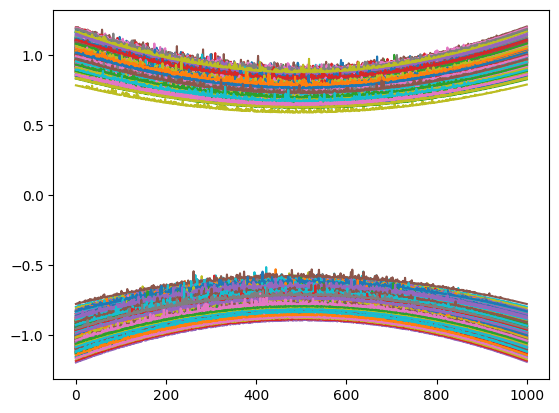

In [5]:
## visualizing interpolant trajectory
## getting sample batch
batch = experiment.get_batch(train = False)
batch = move_batch_to_device(batch, experiment.device)
batch = experiment.preprocessing(batch)
## printing shape
for key, tensor in batch.items():
    print(key, tensor.shape)
## parsing batch dictionary
x0 = batch["x0"]
x1 = batch["x1"]
xc = batch["xc"]
y = batch["y"]
## dscretizing the time interval
time, stepsizes = construct_time_discretization(args["num_time_steps"], device = experiment.device)
## allocating memory
interpolant_trajectory = torch.zeros((args["num_time_steps"] + 1, args["num_sims"], args["num_dims"]), device = experiment.device)
## sampling noise
noise = torch.randn((args["num_time_steps"] + 1, args["num_sims"], args["num_dims"]), device = experiment.device)
## definig iterator
iterator = tqdm(range(args["num_time_steps"] + 1))
for s in iterator:
    ## retrieving current terms
    t = time[s]*torch.ones((args["num_sims"], args["num_dims"]), device = experiment.device)
    z = noise[s]
    ## constructing batch
    mc_batch = {"t": t, "x0": x0, "x1": x1, "xc": xc, "z": z, "y": y}
    ## computing interpolant
    xs = experiment.interpolant.interpolant(mc_batch)
    ## storing result
    interpolant_trajectory[s] = xs
## plotting trajectory of interpolant
print(interpolant_trajectory.shape)
plt.plot(interpolant_trajectory[:, :, 0].cpu())
## asserting equality
x1 = torch.squeeze(x1).cpu()
xt = torch.squeeze(interpolant_trajectory[-1]).cpu()
print(torch.equal(x1, xt))

In [6]:
## standardization
batch = experiment.get_batch()
print(f"STANDARDIZATION: {experiment.preprocessing.params}")
print("BEFORE STANDARDIZATION\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)
batch = experiment.preprocessing(batch)
print("\nAFTER PREPROCESSING\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)
batch = experiment.preprocessing.unstandardize(batch)
print("\nAFTER POSTPROCESSING\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)

STANDARDIZATION: {'mean_x': tensor(-0.0255), 'mean_y': tensor(-0.0255), 'std_x': tensor(3.1436), 'std_y': tensor(3.2988)}
BEFORE STANDARDIZATION

x0 -> mean:  tensor(-0.0240) , std:  tensor(3.1399) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(-0.0244) , std:  tensor(3.1404) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(-0.0240) , std:  tensor(3.1399) shape:  torch.Size([1000, 1])
y -> mean:  tensor(-0.0405) , std:  tensor(3.2660) shape:  torch.Size([1000, 1])

AFTER PREPROCESSING

x0 -> mean:  tensor(0.0005) , std:  tensor(0.9988) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(0.0004) , std:  tensor(0.9990) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(0.0005) , std:  tensor(0.9988) shape:  torch.Size([1000, 1])
y -> mean:  tensor(-0.0045) , std:  tensor(0.9901) shape:  torch.Size([1000, 1])

AFTER POSTPROCESSING

x0 -> mean:  tensor(-0.0240) , std:  tensor(3.1399) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(-0.0244) , std:  tensor(3.1404) shape:  torch.Size([1000

Grad Step 300/300, MSELoss: 0.25089260935783386, Learning Rate 0.001: 100%|██████████| 300/300 [01:43<00:00,  2.89it/s]

loss_history.shape=torch.Size([300]), lr_history.shape=torch.Size([300])


Text(0, 0.5, 'Learning Rate')

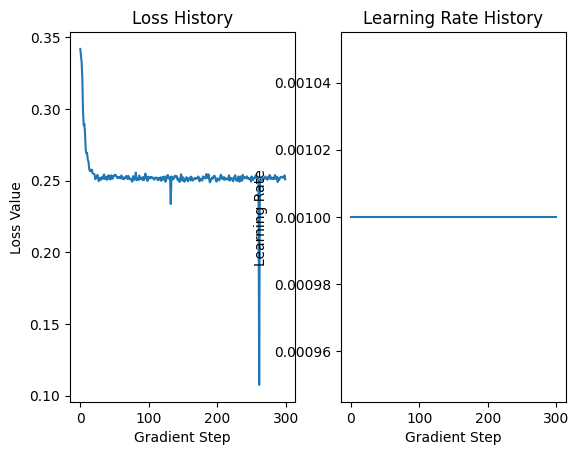

In [7]:
## training
## initializing optimizer and scheduler
b_net_optimizer = OPTIMIZERS[args["b_net_optimizer"]](experiment.b_net.backbone.parameters(), lr = args["b_net_lr"])
b_net_scheduler = SCHEDULERS[args["b_net_scheduler"]]
if b_net_scheduler is not None:
    b_net_scheduler = b_net_scheduler(b_net_optimizer, args["num_grad_steps"])

## constructing optimization config dictionary
b_net_optim_config = {
    "b_net_optimizer": b_net_optimizer,
    "b_net_scheduler": b_net_scheduler,
    "num_grad_steps": args["num_grad_steps"],
}

## training b_net 
train_dict = experiment.train_drift(b_net_optim_config)
loss_history = train_dict["loss_history"]
lr_history = train_dict["lr_history"]
## optional logging
if args["log_results"]:
    ## saving the model
    torch.save(experiment.b_net.state_dict(), os.path.join(args["dump_dir"], "b_net.pt"))
## displaying the shape of the results
print(f"{loss_history.shape=}, {lr_history.shape=}")
## plotting loss and lr history
fix, axes = plt.subplots(1, 2)
## plotting loss 
axes[0].plot(loss_history)
axes[0].set_title("Loss History")
axes[0].set_xlabel("Gradient Step")
axes[0].set_ylabel("Loss Value")
## plotting learning rate
axes[1].plot(lr_history)
axes[1].set_title("Learning Rate History")
axes[1].set_xlabel("Gradient Step")
axes[1].set_ylabel("Learning Rate")

x : torch.Size([1000, 1])
trajectory : torch.Size([1000, 1000, 1])


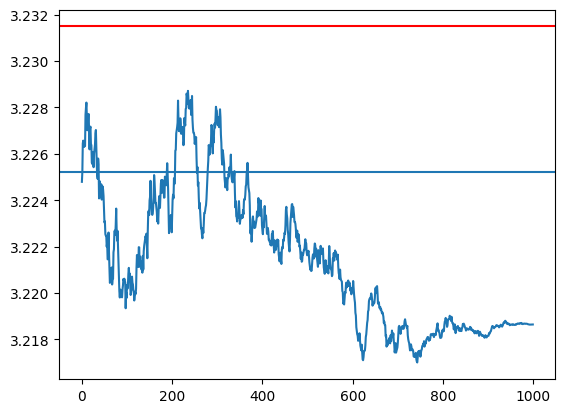

In [8]:
## constructing sampling config dictionary
sde_config = {
    "num_time_steps": args["num_time_steps"],
}

## getting sample batch
batch = experiment.get_batch(train = False)
batch = move_batch_to_device(batch, experiment.device)

## simulating sde on sample batch
sde_dict = experiment.simulate_sde(batch, config = sde_config)
## displaying results shape
for key, tensor in sde_dict.items():
    print(key, f": {tensor.shape}")
## plotting aggregated drift history over optimization
if args["full_out"]:
    ## computing statistics over the mc samples
    mean_trajectory = torch.mean(sde_dict["trajectory"], dim = 1)
    std_trajectory = torch.std(sde_dict["trajectory"], dim = 1)
    ## defining figure and axis
    #fig, axes = plt.subplots()
    #axes.set_title("Simulated trajectories")
    #axes.plot(sde_dict["trajectory"][:, :, 0])
    #axes.plot(mean_trajectory, label = "mean")
    #axes.plot(mean_trajectory + std_trajectory, color = "red", label = "+- std")
    #axes.plot(mean_trajectory - std_trajectory, color = "red")
    #axes.set_xlabel("Time Step")
    #axes.set_ylabel("Trajectory")
    #legend = plt.legend()
    ## plotting sampled trajectory
    plt.plot(sde_dict["trajectory"][:, 0, 0])
    plt.axhline(batch["x0"][0, 0].cpu())
    plt.axhline(batch["x1"][0, 0].cpu(), color = "red")


In [9]:
## constructing sampling config dictionary
sample_config = {
    "num_time_steps": args["num_time_steps"],
    "num_samples": args["num_samples"]
}

## getting sample batch
batch = experiment.get_batch(train = False)
batch = move_batch_to_device(batch, experiment.device)

## sampling from model
sample_dict = experiment.sample(batch, config = sample_config)
## parsing samples dict
samples = sample_dict["samples"]
if args["full_out"]:
    trajectory = sample_dict["trajectory"]

## sampling from gt state transition
x = batch["x0"]
samples_gt = torch.zeros_like(samples)
## defining progress bar
iterator = tqdm(range(args["num_samples"]))
for sample_id in iterator:
    x1 = experiment.ssm.state_transition(x)
    samples_gt[sample_id] = x1
## displaying the shape of the results
print(f"{samples.shape=}", end = "") 
if args["full_out"]:
    print(f", {trajectory.shape=}, {samples_gt.shape=}")

100%|██████████| 450/450 [00:00<00:00, 18213.76it/s]

samples.shape=torch.Size([450, 1000, 1]), trajectory.shape=torch.Size([450, 1000, 1000, 1]), samples_gt.shape=torch.Size([450, 1000, 1])


tensor(-171.6486)


/tmp/ipykernel_17939/2147012076.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


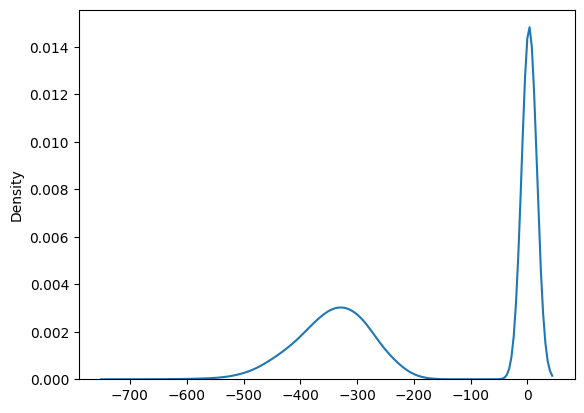

In [10]:
## constructing batch for computing log likelihood
logpdf_dict = {"x0": x.cpu(), "samples": samples}
logpdf_out = experiment.logpdf(logpdf_dict)
print(logpdf_out["mean"])
fig, axes = plt.subplots()
sns.kdeplot(logpdf_out["no_reduction"])
## logging estimated log likelihood
if args["log_results"]:
    experiment.writer.add_figure("metrics/log_likelihood", fig)
else:
    fig.show()

/tmp/ipykernel_17939/1065240134.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


gt_dist.shape=torch.Size([450]), torch.Size([450])
gt_dist.mean()=tensor(3.3861), predicted_dist.mean()=tensor(3.3859)
gt_dist.std()=tensor(0.0100), predicted_dist.std()=tensor(0.0108)
x[observation_idx,:]=tensor([3.3862], device='cuda:0')


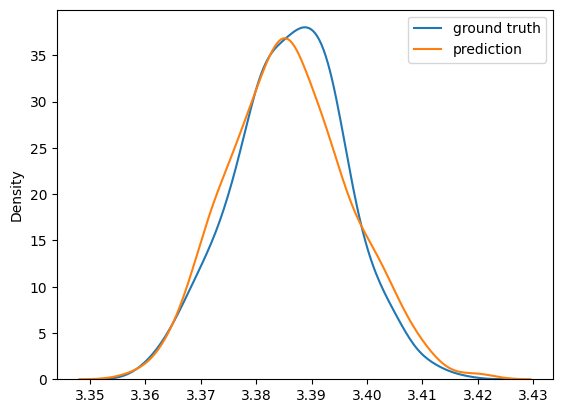

In [11]:
## plotting example histogram
observation_idx = 100
gt_dist = samples_gt[:, observation_idx, 0]
predicted_dist = samples[:, observation_idx, 0]
print(f"{gt_dist.shape=}, {predicted_dist.shape}")
print(f"{gt_dist.mean()=}, {predicted_dist.mean()=}")
print(f"{gt_dist.std()=}, {predicted_dist.std()=}")
fig, axes = plt.subplots()
axes = sns.kdeplot(gt_dist, label = "ground truth")
axes = sns.kdeplot(predicted_dist, label = "prediction")
## plotting preceeding state
x = batch["x0"]
print(f"{x[observation_idx,:]=}")
## displaying legends
plt.legend()
if args["log_results"]:
    experiment.writer.add_figure("learned_distribution", fig)
else:
    fig.show()

In [12]:
## autoregressive sampling
AR_SAMPLING = True
if AR_SAMPLING:
    ## constructing autoregressive sampling config dictionary
    ar_sample_config = {
        "num_time_steps": args["num_time_steps"],
        "num_ar_steps": args["num_ar_steps"],
        "initial_time_step": args["initial_time_step"],
        "ar_sample_train": args["ar_sample_train"],
    }
    ## getting sample batch
    batch = experiment.get_batch(train = False, idx = args["initial_time_step"])
    batch = move_batch_to_device(batch, experiment.device) 
    ## sampling from model
    sample_dict = experiment.ar_sample(batch, config = ar_sample_config)
    ## parsing samples dict
    ar_samples = sample_dict["ar_samples"]
    ## displaying the shape of the results
    print(f"{ar_samples.shape=}", end = "")
    if args["full_out"]:
        trajectory = sample_dict["trajectory"]
        ## displaying the shape of the results
        print(f", {trajectory.shape=}")
    ## computing statistics over the mc samples
    mean_ar_samples = torch.mean(ar_samples, dim = (0, 2))
    std_ar_samples = torch.std(ar_samples, dim = (0, 2))

100%|██████████| 100/100 [00:31<00:00,  3.13it/s]

ar_samples.shape=torch.Size([100, 1000, 1]), trajectory.shape=torch.Size([100, 1000, 1000, 1])


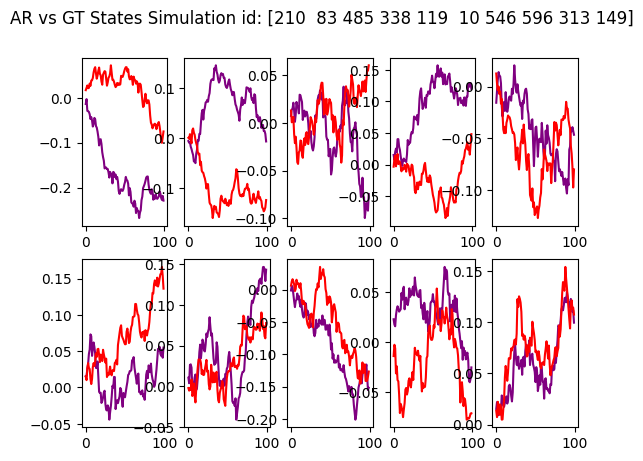

In [13]:
## plotting example trajectory
gt_trajectory = experiment.ssm.test_sim["latent_states"][:ar_sample_config["num_ar_steps"],:,:]
observation_ids = np.random.randint(args["num_sims"], size = (10))
#observation_idx = 200
fig, axes = plt.subplots(2, 5)
fig.suptitle(f"AR vs GT States Simulation id: {observation_ids}")
for idx in range(10):
    r_id = idx//5
    c_id = idx%5
    axes[r_id, c_id].plot(ar_samples[:, observation_ids[idx], ], label = "Ar samples", color = "purple")
    axes[r_id, c_id].plot(gt_trajectory[:,observation_ids[idx], ], label = "GT trajectory", color = "red")
    #axes.plot(ar_samples[:, :, 0], label = "Ar samples", color = "purple")
    #axes.plot(gt_trajectory[:, :, 0], label = "GT trajectory", color = "red")
    #legend = plt.legend()